# 知识蒸馏

对同一个输入x，学生模型$z_s$被要求拟合老师模型$z_t$输出的概率分布 \
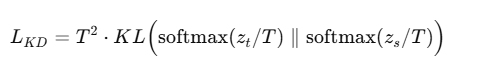 \
$z_T$: 教师模型 logits，$z_s$: 学生模型 logits \
T: 温度（temperature），用于平滑 logits \
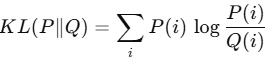 \
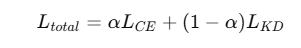 \
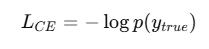

In [2]:
import torch
import torch.nn.functional as F

def distillation_loss_fn(student_logits, teacher_logits, temperature=1.0, reduction='batchmean'):
    # student_logits: [batch_size, seq_len, vocab_size]
    # teacher_logits: [batch_size, seq_len, vocab_size]

    # 1. 计算教师概率分布
    with torch.no_grad():
        # no_grad这段代码里的所有运算都不建立计算题，即不需要反向传播
        # deatch是切断这个tensor和原图的梯度关系
        teacher_probs = F.softmax(teacher_logits / temperature, dim=-1).detach()

    # 2. 计算学生的log softmax
    student_log_probs = F.log_softmax(student_logits / temperature, dim=-1)

    # 3. 计算KL散度
    kl = F.kl_div(
        student_log_probs,
        teacher_probs,
        reduction=reduction,
    )
    
    # 4. 温度缩放补偿
    return (temerature ** 2) * kl

## 知识蒸馏的训练过程

In [3]:
lm_config_student = MiniMindConfig(hidden_size=512, num_hidden_layers=8)
lm_config_teacher = MiniMindConfig(hidden_size=768, num_hidden_layers=16)

NameError: name 'MiniMindConfig' is not defined

In [ ]:
def train_epoch(epoch, wandb, alpha=0.0, temperature=1.0):
    start_time = time.time()

    # 设置教师模型为eval模式，不参与梯度计算
    if teacher_model is not None:
        teacher_model.eval()
        teacher_model.requires_grad_(False)
    
    # 遍历一个epoch中所有的batch
    for step, (X, Y, loss_mask) in enumerate(train_loader):
        X = X.to(args.device)
        Y = Y.to(args.device)
        loss_mask = loss_mask.to(args.device)

        # 获取当前step的学习率
        lr = get_lr(epoch * iter_per_epoch + step,
                    args.epochs * iter_per_epoch,
                    args.learning_rate)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        
        # 学生模型前向传播
        with ctx:
            res = model(X)
            student_logits = res.logits
        
        if teacher_model is not None:
            with torch.no_grad():
                teacher_logits = teacher_model(X).logits

                vocab_size_student = student_logits.size(-1) # 取最后一个维度大小
                teacher_logits = teacher_logits[..., :vocab_size_student] # ...表示前面所有的维度都不变，最后一个维度保证teacher和student的vocab_size一致
        
        # Cross Entropy Loss（标准监督训练）
        loss_mask_flat = loss_mask.view(-1)

        ce_loss = F.cross_entropy(
            student_logits.view(-1, student_logits.size(-1)), # 从（batch, seq_len, vocab_size）拉平成(batch*seq_len, vocab_size)
            Y.view(-1),
            ignore_index=0, #忽略padding token
            reduction='none',
        )

        ce_loss = torch.sum(ce_loss * loss_mask_flat) / loss_mask_flat.sum()

        # 若模型为MoE
        if lm_config_student.use_moe:
            ce_loss += res.aux_loss
        
        # Distillation Loss
        if teacher_model is not None:
            # 筛选有效位置再计算KL蒸馏Loss
            student_logits_flat = student_logits.view(-1, student_logits.size(-1))
            teacher_logits_flat = teacher_logits.view(-1, teacher_logits.size(-1))

            distill_loss = distillation_loss_fn(
                student_logits_flat[loss_mask_flat == 1],
                teacher_logits_flat[loss_mask_flat == 1],
                temperature=temperature
            )
        else:
            distill_loss = torch.tensor(0.0, device=args.device)
        
        # 总损失
        loss = (alpha * ce_loss + (1 - alpha) * distill_loss) / args.accumulation_steps

        # 反向传播
        # fp16算梯度容易全是0或者爆炸，所以scaler.scale会给loss乘上一个动态的放大因子
        scaler.scale(loss).backward()

        # 每accumulation_steps次才执行一次优化器更新
        if (step + 1) % args.accumulation_steps == 0:
            scaler.unscale_(optimizer) # 解除AMP放大,即把因为loss放大导致梯度也放大了的梯度剪裁缩小，unscale_就是把放大了的梯度除回正常尺度
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.grad_clip) # 梯度剪裁
            scaler.step(optimizer) # 优化器更新，检查当前梯度有没有inf/nan，如果正常就更新，不正常就跳过这次更新
            scaler.update() # 根据这次是否有inf/nan来调整下一次的scale，如果有溢出现象就缩小scale，如果没有就放大scale

            optimizer.zero_grad(set_to_none=True) # 清空梯度，更快更省显存




## 推理(Reasoning)模型的知识蒸馏

如果学生模型能学习到教师模型输出的logits信息，这种叫白盒蒸馏 \
如果学生模型只能学习教师模型的最终输出，而不能洞察到logits信息，这种就叫黑盒蒸馏 \
黑盒蒸馏就是把teacher输出的token序列直接当训练标签Y，学生照着学Cross Entropy

In [5]:
# 查看推理模型的训练数据格式

import json
pretrain_dataset_path = r'D:\MiniMind\dataset\r1_mix_1024.jsonl'
with open(pretrain_dataset_path, 'r', encoding='utf-8') as f:
    for line_num, line in enumerate(f,1):
        data = json.loads(line.strip())
        break

print(data)

{'conversations': [{'role': 'user', 'content': '请用一段话描述阿里巴巴集团的企业文化。'}, {'role': 'assistant', 'content': '<think>\n嗯，用户让我用一段话描述阿里巴巴集团的企业文化。首先，我需要明确阿里巴巴集团的平均文化是什么。企业文化的定义是企业内部发生、指导管理方向的准则和规范性的精神或规范。\n\n阿里巴巴集团在2000年代中期开始发展，之前也有类似的概念，比如微软的人工智能理念。所以，我可以从这个发展中来寻找关键词和结构。\n\n接下来，我要考虑用户可能的意图。用户可能想了解阿里巴巴的企业文化，或者需要用于某个报告、宣传材料或者内部交流中。因此，我需要确保描述既全面又有深度，涵盖战略、创新、效率等各个方面。\n\n我还需要用简洁的语言来表达，避免过于复杂的词汇，让段落易于理解。同时，要注意逻辑连贯，段落之间要有过渡，让读者能够顺畅地跟随观点。\n\n可能还需要引用一些关键点，比如战略协作、用户体验、创新、效率、数字化转型、客户支持、全球化等，这些都是阿里巴巴成功的关键点，能够帮助用户全面了解企业文化。\n\n最后，检查语法和结构是否正确，确保专业性和准确性，这样用户可以直接使用这段文字，或者稍作修改，就能得到满意的效果。\n</think>\n<answer>\n阿里巴巴集团的企业文化以战略协作为核心，倡导员工之间的资源整合与创新思维的碰撞，旨在实现企业价值的提升和持续发展。阿里巴巴将其视为一个协同共生的整体，致力于通过技术创新、用户体验优化和数字化转型，致力于为客户创造最大价值。企业内外部力量协同作战，推动企业从单纯的业务拓展延伸至价值创造和社会服务，并在全球范围内进行全方位的数字化转型，以满足多样化、个性化、高端化的客户需求。阿里巴巴集团ix platform的建立旨在帮助员工实现高效协作，激发创新精神，吸引更多优秀人才加入，共同推动企业不断向前发展。\n</answer>'}]}


In [ ]:
# 推理模型的黑盒蒸馏过程
from transformers import AutoTokenizer
import torch.nn as nn
import time

tokenizer = AutoTokenizer.from_pretrained(
    "D:\MiniMind\model",
    use_fast=True
)

def train_epoch(epoch, wandb):
    # 处理标签中的特殊占位符token
    # 注意这里都是一个list，不是单个int
    start_of_think_ids = tokenizer('<think>').input_ids
    end_of_think_ids = tokenizer('</think>').input_ids
    start_of_answer_ids = tokenizer('<answer>').input_ids
    end_of_answer_ids = tokenizer('</answer>').input_ids

    loss_fct = nn.CrossEntropyLoss(reduction='none')
    start_time = time.time()

    for step, (X, Y, loss_mask) in enumerate(train_loader):
        X = X.to(args.device)
        Y = Y.to(args.device)
        loss_mask = loss_mask.to(args.device)

        # 更新学习率
        lr = get_lr(
            epoch * iter_per_epoch + step,
            args.epochs * iter_per_epoch,
            args.learning_rate
        )
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        
        with ctx:
            res = model(X)
            loss = loss_fct(
                res.logits.view(-1, res.logits.size(-1)),
                Y.view(-1)
            ).view(Y.size())

        # 对于batch中每一个token的label(Y)，判断它的token_id，是不是属于<think>和</think>,<answer>和</answer>中的token的任意一个
        special_token_mask = torch.isin(
            Y.view(-1),
            torch.tensor(
                start_of_think_ids +
                end_of_think_ids +
                start_of_answer_ids +
                end_of_answer_ids
            ).to(args.device)
        )

        # 增强特殊token的loss惩罚权重
        loss_mask = loss_mask.view(-1) # [batch_size * seq_len]
        loss_mask_sum = loss_mask.sum() # 总有效token数
        loss_mask[special_token_mask] = 10 # 提升特殊token loss权重为10
        loss_mask = loss_mask.view(Y.size()) # reshape回[batch_size, seq_len]

        # 应用mask后计算最终loss，这里loss是单个样本平均loss
        loss = (loss * loss_mask).sum() / loss_mask_sum

        # 加入辅助loss
        loss += res.aux_loss

        # 梯度累计
        loss = loss / args.accumulation_steps
    # 自动混合精度训练
    scaler.scale(loss).backward()

    # 每accumulation_steps步执行一次反向传播更新
    if (step+1)%args.accumulation_steps == 0:
        scaler.unscale_(optimizer) # 取消缩放用于梯度裁剪
        torch.nn.utils.clip_grad_norm_(
            model.parameters(),
            args.grad_clip
        )
        scaler.step(optimizer)
        scaler.update()

        optimizer.zero_grad(set_to_none=True)



